In [1]:
# https://github.com/vcte/kana

#http://www.java2s.com/Code/Python/GUI-Tk/Canvas.htm

#http://www.java2s.com/Code/Python/GUI-Tk/Canvasinsideaframe.htm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
import tkinter as tk
from PIL import Image, ImageDraw
from tkinter import Text

import os

import torch
from torch import optim
from torchvision import  transforms
from torch.autograd import Variable

from sklearn.model_selection import ParameterGrid

from lib.classifier import *
from lib.utils import *
from lib.models import LeNet_5_3

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-25 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 59%


In [3]:
torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True

In [4]:
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [5]:
model = LeNet_5_3(D_in=(1,28,28), D_out=10, H=128, initialize=None)
_ = model.load_state_dict(torch.load('./LeNet_5_3_model.tar'))

In [6]:
#https://github.com/opensourcesblog/tensorflow-mnist/blob/master/mnist.py

from scipy import ndimage
import cv2

def image_processing(image):
    def getBestShift(img):
        cy,cx = ndimage.measurements.center_of_mass(img)

        rows,cols = img.shape
        shiftx = np.round(cols/2.0-cx).astype(int)
        shifty = np.round(rows/2.0-cy).astype(int)

        return shiftx,shifty

    def shift(img,sx,sy):
        rows,cols = img.shape
        M = np.float32([[1,0,sx],[0,1,sy]])
        shifted = cv2.warpAffine(img,M,(cols,rows))
        return shifted

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(255 - gray_image, (28, 28))
    
    (thresh, gray_image) = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    while np.sum(gray_image[0]) == 0:
            gray_image = gray_image[1:]

    while np.sum(gray_image[:,0]) == 0:
        gray_image = np.delete(gray_image,0,1)

    while np.sum(gray_image[-1]) == 0:
        gray_image = gray_image[:-1]

    while np.sum(gray_image[:,-1]) == 0:
        gray_image = np.delete(gray_image,-1,1)

    rows,cols = gray_image.shape

    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    
    # first cols than rows
    gray_image = cv2.resize(gray_image, (cols, rows))

    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray_image = np.lib.pad(gray_image,(rowsPadding,colsPadding),'constant')

    shiftx,shifty = getBestShift(gray_image)
    gray_image = shift(gray_image,shiftx,shifty)

    gray_image = gray_image.flatten() / 255.0

    return gray_image

In [7]:
class DrawCharacter:
    def __init__(self, model):
        
        self.root=tk.Tk()
        self.root.title("Handwriting Recognition")
        self.root.wm_geometry("%dx%d+%d+%d" % (340, 510, 10, 10))
        self.root.resizable(False,False)
        self.bgColor = "#EDEDED"
        self.root.configure(bg=self.bgColor)
        
        self.x_offset = 30
        self.y_offset = 40
        
        self.width = 280
        self.height = 280
        
        self.button1 = "up"
        
        self.x_old = None
        self.y_old = None 
        
        self.model = model

        self.drawing_area = tk.Canvas(self.root, width=self.width, height=self.height, bg = 'white')
        self.drawing_area.place(x=self.x_offset, y=self.y_offset)

        self.drawing_area.bind("<Motion>", self.motion)
        self.drawing_area.bind("<ButtonPress-1>", self.button_down)
        self.drawing_area.bind("<ButtonRelease-1>", self.button_up)
        
        self.button=tk.Button(self.root,text="Classify", width=7, bg=self.bgColor, command=self.classify) 
        self.button.place(x=self.x_offset, y=5)
        
        self.button1=tk.Button(self.root,text="Erase", width=7, bg=self.bgColor, command=self.erase) 
        self.button1.place(x=self.x_offset + 100, y=5)
        
        self.button1=tk.Button(self.root,text="Exit", width=7, bg=self.bgColor, command=self.exit) 
        self.button1.place(x=self.x_offset + 200, y=5)

        self.text1 = tk.Text(self.root, font=("Helvetica Neue", 12), width=47, height=2, bg = self.bgColor)
        self.text1.place(x=self.x_offset, y=340)
        
        self.text2 = tk.Text(self.root, font=("Helvetica Neue", 12), width=47, height=6, bg = self.bgColor)
        self.text2.place(x=self.x_offset, y=390)

        self._erase()
        
        self.root.mainloop()
        
    def exit(self):
        self.root.destroy()
        
    def classify(self):
        x = np.asarray(self.image, np.uint8)
        x  = image_processing(x)        
        X = np.array([x])
        y_ped = self.predict(X)
        
        self.text1.delete(0.1,tk.END)
        self.text1.insert(0.1,"Top 1:\n" + str(y_ped[0]))       
        
        y_proba = self.predict_proba(X)
        pred = self.top_5(y_proba)
        
        self.text2.delete(0.1,tk.END)
        self.text2.insert(0.1,"Top 5:\n" + "\n".join(map(str, pred)))       

    def top_5(self, y_proba):
        x = Variable(torch.from_numpy(y_proba))
        m = nn.Softmax(dim=1)
        y = m(x).data.numpy().flatten()

        idx = np.flip(np.argsort(y), 0)
        probas = y[idx]
        return [(i,p) for i,p in zip(idx, probas)][0:5]
    
    def predict(self, X):
        y_pred = []

        self.model.eval()
        with torch.no_grad():

            for X_batch in batch(X , 100):
                inputs = torch.from_numpy(X_batch).float()
                inputs = to_var(inputs)

                outputs = self.model(inputs)

                out = torch.max(outputs, 1)[1]
                y_pred.extend( to_np( out ))

        return np.array(y_pred)     
    
    def predict_proba(self, X):
        y_pred = []

        self.model.eval()
        with torch.no_grad():

            for X_batch in batch(X , 100):
                inputs = torch.from_numpy(X_batch).float()
                inputs = to_var(inputs)

                outputs = self.model(inputs)
                y_pred.extend( to_np( outputs ))

        return np.array(y_pred)
        
    def _erase(self):
        self.image=Image.new("RGB",(28,28), 0xFFFFFF).resize((self.width, self.height))
        self.draw=ImageDraw.Draw(self.image)
        
    def erase(self):
        self.drawing_area.delete("all")
        self._erase()
        self.text1.delete(0.1,tk.END)
        self.text2.delete(0.1,tk.END)

    def button_down(self,event):
        self.button1 = "down"

    def button_up(self,event):
        self.button1 = "up"
        self.x_old, self.y_old = None, None

    def motion(self,event):
        if self.button1 == "down":
            if self.x_old is not None and self.y_old is not None:
                event.widget.create_line(self.x_old, self.y_old, event.x, event.y, smooth='true', width=3, fill='black')
                self.draw.line(((self.x_old, self.y_old),(event.x, event.y)),(0, 0, 0),width=15)

        self.x_old, self.y_old = event.x,event.y

In [8]:
d = DrawCharacter(model)

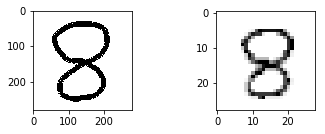

In [9]:
plt.subplot(2, 2, 1)
plt.imshow(d.image, cmap=plt.cm.gray_r, interpolation='nearest')
plt.subplot(2, 2, 2)
plt.imshow(image_processing(np.asarray(d.image, np.uint8)).reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')